### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
wdbc_df=pd.read_csv('data/wdbc.csv')

y_wdbc=wdbc_df['diagnosis']=="M"
X_wdbc=wdbc_df.drop(columns=["id","diagnosis","Unnamed: 32"])

prep_wdbc = Preprocessor()

In [4]:
X_wdbc_train, X_wdbc_test, y_wdbc_train, y_wdbc_test = prep_wdbc.train_test_split(X_wdbc, y_wdbc)

In [5]:
remove_coll,balance_classes,scaling=True,True,False
X_train=X_wdbc_train.copy()
X_test=X_wdbc_test.copy()
y_train=y_wdbc_train.copy()
y_test=y_wdbc_test.copy()
if remove_coll:
    X_train = prep_wdbc.remove_multicollinearity_fit_transform(X_train)
    X_test = prep_wdbc.remove_multicollinearity_transform(X_test)
if balance_classes:
    X_train,y_train=prep_wdbc.class_balancing(X_train,y_train)
if scaling:
    s = StandardScaler()
    X_train = s.fit_transform(X_train)
    X_test = s.transform(X_test)
#próbowałem to wrzucić do funkcji preprocess_data, ale coś wywala błąd więc na razie odpuszczam    
    
#One Hot Encoding
#X_train = prep_wdbc.one_hot_encoding_fit_transform(X_train)
#X_test = prep_wdbc.one_hot_encoding_transform(X_test)

X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

7 numerical features left in dataset  0  categorical
Training dataset has now  534 obervations. 50.0  percent is in positive group.


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [6]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.01, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

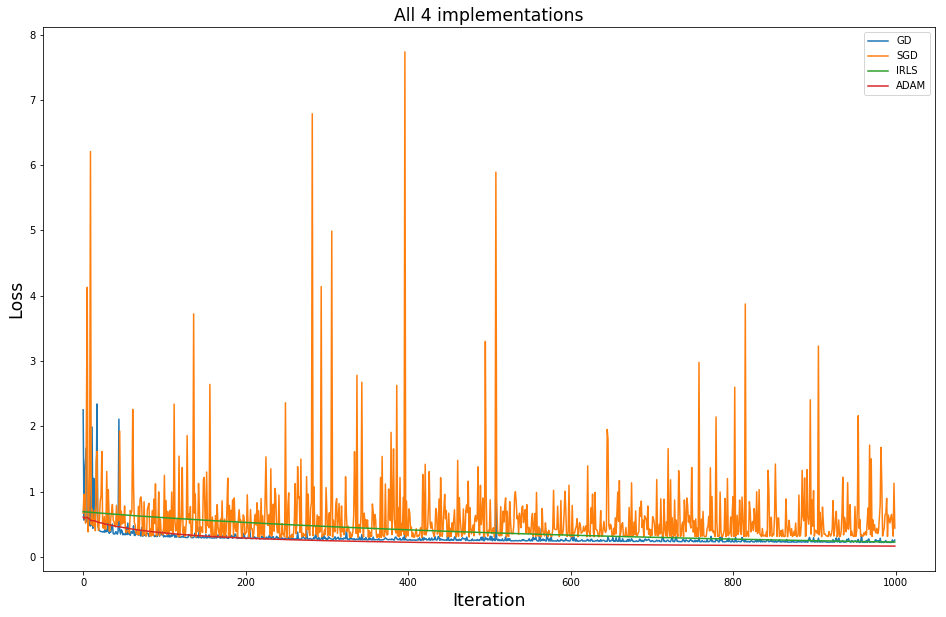

In [7]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()

#### 2. Check how the value of learning rate and other parameters affect the results.

In [19]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=10)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train,y_train,
                                                        X_test,y_test,
                                                        tested_l_rates,tested_algorithms)
res_test_learning_rates.sort_values('accuracy', ascending=False)

,learning_rate,method,accuracy,recall,precision,F_measure
10,0.133337,SGD,0.937,0.925,0.907,0.916
19,0.066673,SGD,0.937,0.906,0.923,0.914
4,0.177779,SGD,0.937,0.925,0.907,0.916
16,0.088894,SGD,0.937,0.925,0.907,0.916
1,0.200000,SGD,0.937,0.925,0.907,0.916
7,0.155558,SGD,0.937,0.925,0.907,0.916
13,0.111116,SGD,0.937,0.925,0.907,0.916
22,0.044452,SGD,0.937,0.906,0.923,0.914
11,0.133337,ADAM,0.930,0.906,0.906,0.906
17,0.088894,ADAM,0.930,0.906,0.906,0.906


In [9]:
res_test_learning_rates[res_test_learning_rates['method']=='ADAM'].sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(3)

,learning_rate,method,accuracy,recall,precision,F_measure
2,0.200000,ADAM,0.93,0.906,0.906,0.906
5,0.177779,ADAM,0.93,0.906,0.906,0.906
8,0.155558,ADAM,0.93,0.906,0.906,0.906


In [14]:
res_test_betas

,beta1,beta2,accuracy,recall,precision,F_measure
0,0.70,0.90,0.370629,1.0,0.370629,0.540816
1,0.70,0.91,0.370629,1.0,0.370629,0.540816
2,0.70,0.92,0.370629,1.0,0.370629,0.540816
3,0.70,0.93,0.370629,1.0,0.370629,0.540816
4,0.70,0.94,0.370629,1.0,0.370629,0.540816
...,...,...,...,...,...,...
105,0.97,0.95,0.370629,1.0,0.370629,0.540816
106,0.97,0.96,0.370629,1.0,0.370629,0.540816
107,0.97,0.97,0.370629,1.0,0.370629,0.540816
108,0.97,0.98,0.370629,1.0,0.370629,0.540816


In [17]:
tested_betas_1=np.linspace(start=0.3,stop=0.97,num=11)
tested_betas_2=np.linspace(start=0.3,stop=0.99,num=10)

res_test_betas=experiments.test_betas(X_train, y_train,
                                      X_test,y_test,
                                      tested_betas_1,tested_betas_2,lr=0.01)
res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure
90,0.903,0.300000,0.944056,0.905660,0.941176,0.923077
91,0.903,0.376667,0.944056,0.905660,0.941176,0.923077
9,0.300,0.990000,0.937063,0.886792,0.940000,0.912621
19,0.367,0.990000,0.937063,0.886792,0.940000,0.912621
29,0.434,0.990000,0.937063,0.886792,0.940000,0.912621
39,0.501,0.990000,0.937063,0.886792,0.940000,0.912621
49,0.568,0.990000,0.937063,0.886792,0.940000,0.912621
59,0.635,0.990000,0.937063,0.886792,0.940000,0.912621
69,0.702,0.990000,0.937063,0.886792,0.940000,0.912621
79,0.769,0.990000,0.937063,0.886792,0.940000,0.912621


#### 3. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [11]:
lr=0.001
n_epochs=1000
models = {
    'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
    'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=1e-3, beta_1=0.75,
                   beta_2=0.99, epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [12]:
res_final=experiments.final_comparisson(X_train, y_train,
                                        X_test,y_test,
                                        models)
res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

,model,accuracy,recall,precision,f_measure
5,QDA,0.944056,0.905660,0.941176,0.923077
2,IRLS,0.944056,0.886792,0.959184,0.921569
1,SGD,0.930070,0.867925,0.938776,0.901961
3,ADAM,0.916084,0.867925,0.901961,0.884615
6,LR,0.916084,0.849057,0.918367,0.882353
7,kNN,0.902098,0.849057,0.882353,0.865385
4,LDA,0.895105,0.754717,0.952381,0.842105
0,GD,0.888112,0.830189,0.862745,0.846154
